# Setup
First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


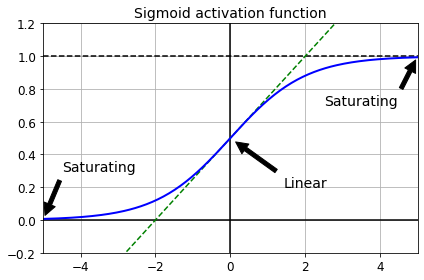

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

# Xavier and He Initialization
Note: the book uses tensorflow.contrib.layers.fully_connected() rather than tf.layers.dense() (which did not exist when this chapter was written). It is now preferable to use tf.layers.dense(), because anything in the contrib module may change or be deleted without notice. The dense() function is almost identical to the fully_connected() function. The main differences relevant to this chapter are:

several parameters are renamed: scope becomes name, activation_fn becomes activation (and similarly the _fn suffix is removed from other parameters such as normalizer_fn), weights_initializer becomes kernel_initializer, etc.
the default activation is now None rather than tf.nn.relu.
it does not support tensorflow.contrib.framework.arg_scope() (introduced later in chapter 11).
it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

Instructions for updating:
Use keras.layers.dense instead.


# Nonsaturating Activation Functions
Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


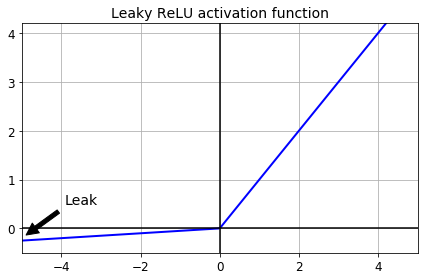

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in TensorFlow:

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [11]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

Warning: tf.examples.tutorials.mnist is deprecated. We will use tf.keras.datasets.mnist instead.

In [18]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [20]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, r"./tf_logs/LeakyReLU/my_model_final.ckpt")
    file_writer = tf.summary.FileWriter(r"./tf_logs/LeakyReLU", tf.get_default_graph())
    file_writer.close()

0 Batch accuracy: 0.86 Validation accuracy: 0.9046
5 Batch accuracy: 0.94 Validation accuracy: 0.9498
10 Batch accuracy: 0.92 Validation accuracy: 0.9656
15 Batch accuracy: 0.94 Validation accuracy: 0.9706
20 Batch accuracy: 1.0 Validation accuracy: 0.976
25 Batch accuracy: 1.0 Validation accuracy: 0.9774
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9786


ELU

In [21]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


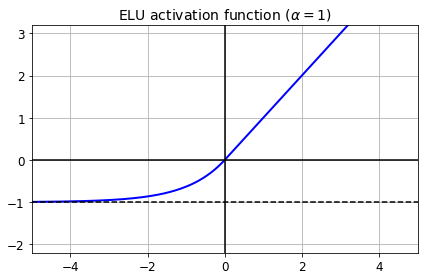

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [24]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

# SELU

This activation function was proposed in this great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, 
published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using 
the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to 
preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. 
As a result, this activation function outperforms the other activation functions very significantly for such 
neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU 
activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, 
skip connections or other non-sequential topologies (so recurrent neural networks 
won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break 
self-normalization, SELU will not necessarily outperform other activation functions.

In [25]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [26]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


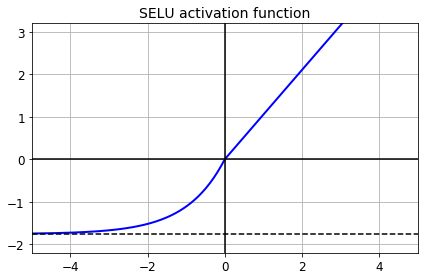

In [27]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [28]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


The tf.nn.selu() function was added in TensorFlow 1.4. For earlier versions, you can use the following implementation:

In [29]:
def selu(z, scale=alpha_0_1, alpha=scale_0_1):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

However, the SELU activation function cannot be used along with regular Dropout (this would cancel the SELU activation function's self-normalizing property). Fortunately, there is a Dropout variant called Alpha Dropout proposed in the same paper. It is available in tf.contrib.nn.alpha_dropout() since TF 1.4 (or check out this implementation by the Institute of Bioinformatics, Johannes Kepler University Linz).

Let's create a neural net for MNIST using the SELU activation function:

In [30]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [31]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, r"./tf_logs/SELU/my_model_final.ckpt")
    file_writer = tf.summary.FileWriter(r"./tf_logs/SELU", tf.get_default_graph())
    file_writer.close()

0 Batch accuracy: 0.94 Validation accuracy: 0.9388
5 Batch accuracy: 0.98 Validation accuracy: 0.9634
10 Batch accuracy: 1.0 Validation accuracy: 0.9694
15 Batch accuracy: 1.0 Validation accuracy: 0.9704
20 Batch accuracy: 1.0 Validation accuracy: 0.9692
25 Batch accuracy: 1.0 Validation accuracy: 0.969
30 Batch accuracy: 1.0 Validation accuracy: 0.9706
35 Batch accuracy: 1.0 Validation accuracy: 0.9704


# Batch Normalization

Note: the book uses tensorflow.contrib.layers.batch_norm() rather than tf.layers.batch_normalization() (which did not exist when this chapter was written). It is now preferable to use tf.layers.batch_normalization(), because anything in the contrib module may change or be deleted without notice. Instead of using the batch_norm() function as a regularizer parameter to the fully_connected() function, we now use batch_normalization() and we explicitly create a distinct layer. The parameters are a bit different, in particular:

decay is renamed to momentum,
is_training is renamed to training,
updates_collections is removed: the update operations needed by batch normalization are added to the UPDATE_OPS collection and you need to explicity run these operations during training (see the execution phase below),
we don't need to specify scale=True, as that is the default.
Also note that in order to run batch norm just before each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the tf.layers.dense() function is incompatible with tf.contrib.layers.arg_scope() (which is used in the book), we now use python's functools.partial() function instead. It makes it easy to create a my_dense_layer() function that just calls tf.layers.dense() with the desired parameters automatically set (unless they are overridden when calling my_dense_layer()). As you can see, the code remains very similar.

In [32]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [33]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

To avoid repeating the same parameters over and over again, we can use Python's partial() function:
https://docs.python.org/3.6/library/functools.html?highlight=partial

In [34]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [35]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: since we are using tf.layers.batch_normalization() rather than tf.contrib.layers.batch_norm() (as in the book), we need to explicitly run the extra update operations needed by batch normalization (sess.run([training_op, extra_update_ops],...).

In [36]:
n_epochs = 20
batch_size = 200

In [37]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, r"./tf_logs/BatchNormalization/my_model_final.ckpt")
    file_writer = tf.summary.FileWriter(r"./tf_logs/BatchNormalization", tf.get_default_graph())
    file_writer.close()

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

Note that you could also make the training operation depend on the update operations:

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
This way, you would just have to evaluate the training_op during training, TensorFlow would automatically run the update operations as well:

sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [38]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [39]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

# Gradient Clipping

Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):

In [40]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [41]:
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the clip_by_value() function to clip them, then apply them:

In [42]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [43]:
# The rest is the same as usual:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [44]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
n_epochs = 20
batch_size = 200

In [46]:
with tf.Session() as sess:
    
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    save_path = saver.save(sess, r"./tf_logs/GradientClipping/my_model_final.ckpt")
    file_writer = tf.summary.FileWriter(r"./tf_logs/GradientClipping", tf.get_default_graph())
    file_writer.close()

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7942
2 Validation accuracy: 0.8796
3 Validation accuracy: 0.906
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9216
6 Validation accuracy: 0.929
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9454
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9478
13 Validation accuracy: 0.953
14 Validation accuracy: 0.9566
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.959
18 Validation accuracy: 0.962
19 Validation accuracy: 0.9618


# Reusing Pretrained Layers

# Reusing a TensorFlow Model
First you need to load the graph's structure. The import_meta_graph() function does just that, loading the graph's operations into the default graph, and returning a Saver that you can then use to restore the model's state. Note that by default, a Saver saves the structure of the graph into a .meta file, so that's the file you should load:

In [47]:
reset_graph()

In [48]:
saver = tf.train.import_meta_graph("./tf_logs/GradientClipping/my_model_final.ckpt.meta")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [49]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

Oops, that's a lot of operations! you will need to use a FileWriter to save the graph and then visualize it in TensorBoard)
start tenssorboard and check graph
[i328815@MacPro ~/Documents/Notes_HandsOn_ML]$ tensorboard --logdir tf_logs/

Once you know which operations you need, you can get a handle on them using the graph's get_operation_by_name() or get_tensor_by_name() methods:

In [50]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [51]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [52]:
#This way people who reuse your model will be able to simply write:
#X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now you can start a session, restore the model's state and continue training on your data:

In [53]:
with tf.Session() as sess:
    saver.restore(sess, "./tf_logs/GradientClipping/my_model_final.ckpt")
    # continue training the model...

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tf_logs/GradientClipping/my_model_final.ckpt


Actually, let's test this for real!

In [54]:
with tf.Session() as sess:
    saver.restore(sess, "./tf_logs/GradientClipping/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./tf_logs/GradientClipping/my_new_model_final.ckpt")   

INFO:tensorflow:Restoring parameters from ./tf_logs/GradientClipping/my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.963
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9686
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9684
9 Validation accuracy: 0.9684
10 Validation accuracy: 0.9702
11 Validation accuracy: 0.9716
12 Validation accuracy: 0.9676
13 Validation accuracy: 0.97
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.972
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9708


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of import_meta_graph():

In [55]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

And continue training:

In [56]:
with tf.Session() as sess:
    saver.restore(sess, "./tf_logs/GradientClipping/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./tf_logs/GradientClipping/my_new_model_final.ckpt") 

INFO:tensorflow:Restoring parameters from ./tf_logs/GradientClipping/my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.963
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9686
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9684
9 Validation accuracy: 0.9684
10 Validation accuracy: 0.9702
11 Validation accuracy: 0.9716
12 Validation accuracy: 0.9676
13 Validation accuracy: 0.97
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.972
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9708


In general you will want to reuse only the lower layers. If you are using import_meta_graph() it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [57]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./tf_logs/GradientClipping/my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [58]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./tf_logs/GradientClipping/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./tf_logs/GradientClipping/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./tf_logs/GradientClipping/my_model_final.ckpt
0 Validation accuracy: 0.9184
1 Validation accuracy: 0.9394
2 Validation accuracy: 0.949
3 Validation accuracy: 0.9526
4 Validation accuracy: 0.9556
5 Validation accuracy: 0.956
6 Validation accuracy: 0.9576
7 Validation accuracy: 0.961
8 Validation accuracy: 0.9612
9 Validation accuracy: 0.9644
10 Validation accuracy: 0.965
11 Validation accuracy: 0.966
12 Validation accuracy: 0.9642
13 Validation accuracy: 0.967
14 Validation accuracy: 0.9684
15 Validation accuracy: 0.9682
16 Validation accuracy: 0.97
17 Validation accuracy: 0.9674
18 Validation accuracy: 0.9694
19 Validation accuracy: 0.9704


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [59]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one Saver to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another Saver to save the new model, once it is trained:

In [60]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./tf_logs/GradientClipping/my_model_final.ckpt")

    for epoch in range(n_epochs):                                            
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): 
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     
        print(epoch, "Validation accuracy:", accuracy_val)                   

    save_path = saver.save(sess, "./tf_logs/GradientClipping/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./tf_logs/GradientClipping/my_model_final.ckpt
0 Validation accuracy: 0.903
1 Validation accuracy: 0.9334
2 Validation accuracy: 0.9426
3 Validation accuracy: 0.9472
4 Validation accuracy: 0.9522
5 Validation accuracy: 0.9532
6 Validation accuracy: 0.9556
7 Validation accuracy: 0.959
8 Validation accuracy: 0.9588
9 Validation accuracy: 0.9608
10 Validation accuracy: 0.962
11 Validation accuracy: 0.9618
12 Validation accuracy: 0.9638
13 Validation accuracy: 0.966
14 Validation accuracy: 0.9664
15 Validation accuracy: 0.9658
16 Validation accuracy: 0.967
17 Validation accuracy: 0.9674
18 Validation accuracy: 0.9684
19 Validation accuracy: 0.9672


# Reusing Models from Other Frameworks

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a feed_dict:

In [61]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [62]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[ 61.  83. 105.]]


Note: the weights variable created by the tf.layers.dense() function is called "kernel" (instead of "weights" when using the tf.contrib.layers.fully_connected(), as in the book), and the biases variable is called bias instead of biases.

Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [63]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using get_collection() and specifying the scope:

In [64]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's get_tensor_by_name() method:

In [65]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [66]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

# Freezing the Lower Layers

In [67]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [68]:
with tf.name_scope("train"):                                         
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [69]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./tf_logs/GradientClipping/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./tf_logs/GradientClipping/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./tf_logs/GradientClipping/my_model_final.ckpt
0 Validation accuracy: 0.8964
1 Validation accuracy: 0.9304
2 Validation accuracy: 0.9404
3 Validation accuracy: 0.9442
4 Validation accuracy: 0.948
5 Validation accuracy: 0.9506
6 Validation accuracy: 0.9508
7 Validation accuracy: 0.9536
8 Validation accuracy: 0.9556
9 Validation accuracy: 0.9566
10 Validation accuracy: 0.9558
11 Validation accuracy: 0.9568
12 Validation accuracy: 0.9568
13 Validation accuracy: 0.9572
14 Validation accuracy: 0.9586
15 Validation accuracy: 0.9578
16 Validation accuracy: 0.9574
17 Validation accuracy: 0.9596
18 Validation accuracy: 0.9594
19 Validation accuracy: 0.9602


In [70]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [71]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [72]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [73]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./tf_logs/GradientClipping/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./tf_logs/GradientClipping/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./tf_logs/GradientClipping/my_model_final.ckpt
0 Validation accuracy: 0.902
1 Validation accuracy: 0.9306
2 Validation accuracy: 0.9432
3 Validation accuracy: 0.9476
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.952
7 Validation accuracy: 0.9554
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9562
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9578
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9574
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.958


# Caching the Frozen Layers

In [74]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [75]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [76]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./tf_logs/GradientClipping/my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./tf_logs/GradientClipping/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./tf_logs/GradientClipping/my_model_final.ckpt
0 Validation accuracy: 0.902
1 Validation accuracy: 0.9306
2 Validation accuracy: 0.9432
3 Validation accuracy: 0.9476
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.952
7 Validation accuracy: 0.9554
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9562
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9578
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9574
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.958


# Faster Optimizers

In [77]:
# Momentum optimization
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

In [78]:
# Nesterov Accelerated Gradient
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

In [79]:
# AdaGrad
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

In [80]:
# RMSProp
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

In [81]:
# Adam Optimization
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

Learning Rate Scheduling

In [82]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [83]:
with tf.name_scope("train"):       
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [84]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [85]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./tf_logs/GradientClipping/my_model_final.ckpt")

0 Validation accuracy: 0.962
1 Validation accuracy: 0.9744
2 Validation accuracy: 0.9794
3 Validation accuracy: 0.981
4 Validation accuracy: 0.9838


# Avoiding Overfitting Through Regularization

# ℓ1  and  ℓ2  regularization
Let's implement  ℓ1  regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [86]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the  ℓ1  loss (i.e., the absolute values of the weights):

In [87]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [88]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [89]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./tf_logs/L1L2Regularization/my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9066
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


Alternatively, we can pass a regularization function to the tf.layers.dense() function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [90]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

Next, we will use Python's partial() function to avoid repeating the same arguments over and over again. Note that we set the kernel_regularizer argument:

In [91]:
scale = 0.001

In [92]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Next we must add the regularization losses to the base loss:

In [93]:
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  
        labels=y, logits=logits)                                
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

And the rest is the same as usual:

In [94]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [95]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./tf_logs/L1L2Regularization//my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.908
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9124
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9224
15 Validation accuracy: 0.9216
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


# Dropout

Note: the book uses tf.contrib.layers.dropout() rather than tf.layers.dropout() (which did not exist when this chapter was written). It is now preferable to use tf.layers.dropout(), because anything in the contrib module may change or be deleted without notice. The tf.layers.dropout() function is almost identical to the tf.contrib.layers.dropout() function, except for a few minor differences. Most importantly:

you must specify the dropout rate (rate) rather than the keep probability (keep_prob), where rate is simply equal to 1 - keep_prob,
the is_training parameter is renamed to training.

In [96]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [97]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

Instructions for updating:
Use keras.layers.dropout instead.


In [98]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [99]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./tf_logs/DropOut/my_model_final.ckpt")

0 Validation accuracy: 0.9246
1 Validation accuracy: 0.9458
2 Validation accuracy: 0.9496
3 Validation accuracy: 0.9494
4 Validation accuracy: 0.9614
5 Validation accuracy: 0.9632
6 Validation accuracy: 0.9628
7 Validation accuracy: 0.9674
8 Validation accuracy: 0.9668
9 Validation accuracy: 0.9666
10 Validation accuracy: 0.969
11 Validation accuracy: 0.969
12 Validation accuracy: 0.9706
13 Validation accuracy: 0.9702
14 Validation accuracy: 0.9728
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.9738
17 Validation accuracy: 0.9722
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9748


# Max norm

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [100]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the clip_by_norm() function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [101]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [102]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [103]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the training_op, we run the clip_weights and clip_weights2 operations:

In [104]:
n_epochs = 20
batch_size = 50

In [105]:
with tf.Session() as sess:                                             
    init.run()                                                          
    for epoch in range(n_epochs):                                       
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): 
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   
        print(epoch, "Validation accuracy:", acc_valid)                 

    save_path = saver.save(sess, "./tf_logs/MaxNorm/my_model_final.ckpt")              

0 Validation accuracy: 0.9568
1 Validation accuracy: 0.97
2 Validation accuracy: 0.9712
3 Validation accuracy: 0.9774
4 Validation accuracy: 0.9784
5 Validation accuracy: 0.977
6 Validation accuracy: 0.9824
7 Validation accuracy: 0.9816
8 Validation accuracy: 0.9814
9 Validation accuracy: 0.9818
10 Validation accuracy: 0.9828
11 Validation accuracy: 0.985
12 Validation accuracy: 0.9832
13 Validation accuracy: 0.9836
14 Validation accuracy: 0.9846
15 Validation accuracy: 0.9844
16 Validation accuracy: 0.9844
17 Validation accuracy: 0.984
18 Validation accuracy: 0.985
19 Validation accuracy: 0.9852


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a max_norm_regularizer() function:

In [106]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the kernel_regularizer argument:

In [107]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [108]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [109]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [110]:
n_epochs = 20
batch_size = 50

In [111]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) 
        print(epoch, "Validation accuracy:", acc_valid)               

    save_path = saver.save(sess, "./tf_logs/MaxNorm/my_model_final.ckpt")            

0 Validation accuracy: 0.9558
1 Validation accuracy: 0.97
2 Validation accuracy: 0.9726
3 Validation accuracy: 0.975
4 Validation accuracy: 0.976
5 Validation accuracy: 0.9788
6 Validation accuracy: 0.9808
7 Validation accuracy: 0.9812
8 Validation accuracy: 0.981
9 Validation accuracy: 0.9812
10 Validation accuracy: 0.9816
11 Validation accuracy: 0.9826
12 Validation accuracy: 0.9808
13 Validation accuracy: 0.9822
14 Validation accuracy: 0.9822
15 Validation accuracy: 0.9822
16 Validation accuracy: 0.9818
17 Validation accuracy: 0.982
18 Validation accuracy: 0.9812
19 Validation accuracy: 0.982
